# Figure 3 - DL model/impulse-response schematic
#### Christopher Callahan
#### Christopher.W.Callahan.GR@dartmouth.edu

#### Mechanics
Dependencies

In [1]:
import xarray as xr
import numpy as np
import sys
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import seaborn as sns
from rasterio import features
from affine import Affine
import geopandas as gp
import descartes
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from scipy import stats

Data locations

In [2]:
loc_panel = "../Data/Panel/"
loc_regression = "../Data/RegressionResults/"
loc_shp = "../Data/Shapefile/"

#### Analysis

Read panel to get scalings etc

In [3]:
edd_type = "month"
panel = pd.read_csv(loc_panel+"extremes_growth_panel_"+edd_type+"edd_1979-2016.csv",index_col=0)

Simulate fake data

In [4]:
nyr = 8
event_yr = 3
coefs = [-0.02,-0.02,0.03,0.01]
gr_df = pd.DataFrame({"time":np.arange(1,nyr+1,1)})

gr_df["gr_default"] = np.full(int(nyr),0.03)
gr_df["income_default"] = np.zeros(nyr)
for n in np.arange(1,nyr+1,1):
    if n==1:
        gr_df.loc[gr_df.time==n,"income_default"] = 1
    else:
        prev = gr_df.loc[gr_df.time==n-1,"income_default"].values[0]
        gr = gr_df.loc[gr_df.time==n,"gr_default"].values[0]
        gr_df.loc[gr_df.time==n,"income_default"] = prev + (prev * gr_df.loc[gr_df.time==n,"gr_default"])

Add damages to fake data

In [5]:
gr_df["gr_hw"] = gr_df["gr_default"].values
event_ind = (gr_df.time>=event_yr)&(gr_df.time<(event_yr+len(coefs)))
for ee in np.arange(0,len(coefs),1):
    e = event_yr+ee-1
    gr_df.loc[e,"gr_hw"] = gr_df.loc[e,"gr_hw"] + coefs[ee]
gr_df["income_hw"] = np.zeros(nyr)
for n in np.arange(1,nyr+1,1):
    if n==1:
        gr_df.loc[gr_df.time==n,"income_hw"] = 1
    else:
        prev = gr_df.loc[gr_df.time==n-1,"income_hw"].values[0]
        gr = gr_df.loc[gr_df.time==n,"gr_hw"].values[0]
        gr_df.loc[gr_df.time==n,"income_hw"] = prev + (prev * gr_df.loc[gr_df.time==n,"gr_hw"])

In [6]:
gr_df

,time,gr_default,income_default,gr_hw,income_hw
0,1,0.03,1.000000,0.03,1.000000
1,2,0.03,1.030000,0.03,1.030000
2,3,0.03,1.060900,0.01,1.040300
3,4,0.03,1.092727,0.01,1.050703
4,5,0.03,1.125509,0.06,1.113745
5,6,0.03,1.159274,0.04,1.158295
6,7,0.03,1.194052,0.03,1.193044
7,8,0.03,1.229874,0.03,1.228835


Plot

/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/pyth

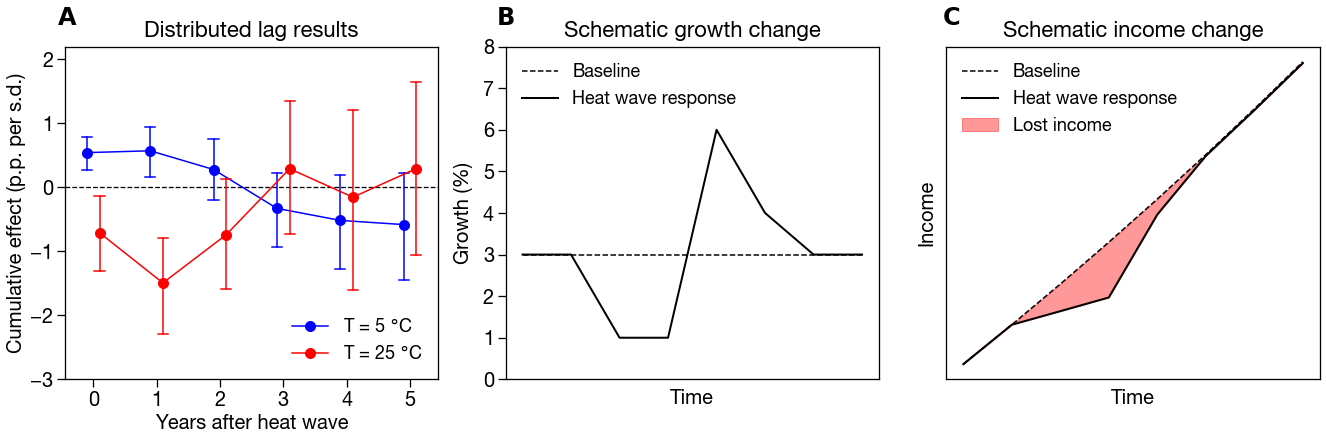

In [7]:
fig = plt.figure(figsize=(21,6))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 20.0
rcParams["axes.linewidth"] = 1.3
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3

gs1 = gridspec.GridSpec(1,3)
gs1.update(left=0.12,right=0.95,top=0.89,bottom=0.12,wspace=0.18,hspace=0.3)

nlag = 5
boot_type = "region"
extr = "tx5d"
scaling = 100*np.nanmean(panel.groupby("region").std()[extr].values)
tfs = 22


ax = plt.subplot(gs1[0,0])

lags = np.arange(0,nlag+1,1)
ts = np.arange(-5,35+1,1)
tx_dl = pd.DataFrame({"lag":np.repeat(lags,len(ts)),
                      "ts":np.tile(ts,len(lags)).flatten(),
                      "ame":np.zeros(len(np.repeat(lags,len(ts)))),
                      "ci_upper":np.zeros(len(np.repeat(lags,len(ts)))),
                      "ci_lower":np.zeros(len(np.repeat(lags,len(ts))))})

coefs_main_dist = pd.read_csv(loc_regression+extr+"_coefs_bootstrap_"+boot_type+"_lag"+str(nlag)+".csv",index_col=0)
coefs_interact_dist = pd.read_csv(loc_regression+extr+"_coefs_interact_bootstrap_"+boot_type+"_lag"+str(nlag)+".csv",index_col=0)
nboot = len(coefs_main_dist.boot.values)
for l in lags:
    coef_main_sums = np.sum(coefs_main_dist.iloc[:,1:(2+l)].values,axis=1)
    coef_interact_sums = np.sum(coefs_interact_dist.iloc[:,1:(2+l)].values,axis=1)        
    me_matrix = np.zeros((len(ts),nboot))
    for n in np.arange(0,nboot,1):
        me_matrix[:,n] = (coef_main_sums[n] + (coef_interact_sums[n]*ts))*scaling
    tx_dl.loc[tx_dl.lag.values==l,"ame"] = np.mean(me_matrix,axis=1)
    tx_dl.loc[tx_dl.lag.values==l,"ci_upper"] = np.percentile(me_matrix,97.5,axis=1)
    tx_dl.loc[tx_dl.lag.values==l,"ci_lower"] = np.percentile(me_matrix,2.5,axis=1)
    
ts_examples = [5,25]
example_cols = ["blue","red"]
jitter = [-0.1,0.1]

for tt in np.arange(0,len(ts_examples),1):
    jtr = jitter[tt]
    tse = ts_examples[tt]
    cc = example_cols[tt]
    tx_dl_example = tx_dl.loc[(tx_dl.ts.values==tse),:]
    plt.plot(tx_dl_example.lag+jtr,
             tx_dl_example.ame,color=cc,marker="o",
             markersize=10,linewidth=1.5,
             label="T = "+str(tse)+" $\degree$C")
    
    for j in tx_dl_example.lag:
        ci_u = tx_dl_example.loc[tx_dl_example.lag==j,"ci_upper"].values
        ci_l = tx_dl_example.loc[tx_dl_example.lag==j,"ci_lower"].values
        x = j + jtr
        plt.plot([x,x],[ci_l,ci_u],
                  color=cc,linewidth=1.5)
        plt.plot([x-0.08,x+0.08],[ci_l,ci_l],
                linewidth=1.5,color=cc)
        plt.plot([x-0.08,x+0.08],[ci_u,ci_u],
                linewidth=1.5,color=cc)
    
    
plt.legend(loc="lower right",frameon=False,fontsize=18)
plt.ylim([-3,2.2])
#plt.yticks([-3,-2,-1,0,1])
#plt.yticks([-4,-2,0,2])
plt.xticks(np.arange(0,nlag+1,1))
plt.ylabel("Cumulative effect (p.p. per s.d.)")
plt.xlabel("Years after heat wave")
plt.axhline(y=0,linewidth=1.3,color="black",linestyle="--",zorder=1)
plt.title("Distributed lag results",pad=10,fontsize=tfs)



## now schematic for growth change
ax = plt.subplot(gs1[0,1])

plt.plot(gr_df.time,gr_df.gr_default*100,color="black",linewidth=1.5,
        linestyle="--",label="Baseline")
plt.plot(gr_df.time,gr_df.gr_hw*100,color="black",linewidth=2,
        linestyle="-",label="Heat wave response")

plt.ylim([0,8])
#plt.yticks([])
plt.xticks([])
plt.ylabel("Growth (%)",labelpad=10)
plt.xlabel("Time",labelpad=10)
plt.legend(loc="upper left",frameon=False,fontsize=18)
plt.title("Schematic growth change",pad=10,fontsize=tfs)


## schematic for resulting income change
ax = plt.subplot(gs1[0,2])

plt.plot(gr_df.time,gr_df.income_default,linewidth=1.5,
         linestyle="--",zorder=1,color="black",
        label="Baseline")
plt.plot(gr_df.time,gr_df.income_hw,linewidth=2,
        linestyle="-",zorder=3,color="black",
        label="Heat wave response")
ax.fill_between(gr_df.time,gr_df.income_hw,
               gr_df.income_default,color="red",
               alpha=0.4,label="Lost income")


plt.yticks([])
plt.xticks([])
plt.ylabel("Income",labelpad=10)
plt.xlabel("Time",labelpad=10)
plt.legend(loc="upper left",frameon=False,fontsize=18)
plt.title("Schematic income change",pad=10,fontsize=tfs)


plt.figtext(0.115,0.94,r'$\bf{A}$',fontsize=24)
plt.figtext(0.405,0.94,r'$\bf{B}$',fontsize=24)
plt.figtext(0.7,0.94,r'$\bf{C}$',fontsize=24)

plt.savefig("../Figures/Fig3.pdf")
plt.show()